In [5]:
import pandas as pd
#from pyspark.mllib.clustering import KMeans, KMeansModel
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
plt.figure();

In [6]:
adclicksDF = pd.read_csv("../from_coursera/big_data_capstone_datasets_and_scripts/flamingo-data/ad-clicks.csv")
adclicksDF = adclicksDF.rename(columns=lambda x: x.strip())
adclicksDF['adCount'] = 1
adclicksDF.head(5)

,timestamp,txId,userSessionId,teamId,userId,adId,adCategory,adCount
0,2016-05-26 15:13:22,5974,5809,27,611,2,electronics,1
1,2016-05-26 15:17:24,5976,5705,18,1874,21,movies,1
2,2016-05-26 15:22:52,5978,5791,53,2139,25,computers,1
3,2016-05-26 15:22:57,5973,5756,63,212,10,fashion,1
4,2016-05-26 15:22:58,5980,5920,9,1027,20,clothing,1


In [7]:
buyclicksDF = pd.read_csv("../from_coursera/big_data_capstone_datasets_and_scripts/flamingo-data/buy-clicks.csv")
buyclicksDF = buyclicksDF.rename(columns=lambda x: x.strip())
buyclicksDF.head(5)

,timestamp,txId,userSessionId,team,userId,buyId,price
0,2016-05-26 15:36:54,6004,5820,9,1300,2,3.0
1,2016-05-26 15:36:54,6005,5775,35,868,4,10.0
2,2016-05-26 15:36:54,6006,5679,97,819,5,20.0
3,2016-05-26 16:36:54,6067,5665,18,121,2,3.0
4,2016-05-26 17:06:54,6093,5709,11,2222,5,20.0


In [8]:
sesDF = pd.read_csv("../from_coursera/big_data_capstone_datasets_and_scripts/flamingo-data/user-session.csv")
sesDF = sesDF.rename(columns=lambda x: x.strip())
sesDF.head(5)

,timestamp,userSessionId,userId,teamId,assignmentId,sessionType,teamLevel,platformType
0,2016-05-26 14:47:30,5675,170,90,5423,start,1,iphone
1,2016-05-27 00:06:54,5675,170,90,5423,end,1,iphone
2,2016-05-26 14:43:09,5795,835,39,5300,start,1,android
3,2016-05-27 08:06:54,5795,835,39,5300,end,1,android
4,2016-05-26 14:47:20,5833,624,2,5529,start,1,iphone


In [9]:
# Calculate Time Difference
sessStart = sesDF[sesDF["sessionType"] == "start"].reset_index()
sessStart = sessStart[["userId","userSessionId","timestamp"]]
sessStart.columns = ["userId","userSessionId","start"]
sessEnd =  sesDF[sesDF["sessionType"] == "end"].reset_index()
sessEnd = sessEnd[["userSessionId","timestamp"]]
sessEnd.columns = ["userSessionId","end"]
sessCombined = sessStart.merge(sessEnd, on='userSessionId')
sessCombined["duration"] = (sessCombined["end"].apply(pd.Timestamp)-sessCombined["start"].apply(pd.Timestamp)).astype('timedelta64[h]')
sessCombined.head(5)

,userId,userSessionId,start,end,duration
0,170,5675,2016-05-26 14:47:30,2016-05-27 00:06:54,9.0
1,835,5795,2016-05-26 14:43:09,2016-05-27 08:06:54,17.0
2,624,5833,2016-05-26 14:47:20,2016-05-27 23:06:54,32.0
3,514,5877,2016-05-26 14:37:33,2016-05-27 23:06:54,32.0
4,2103,5902,2016-05-26 14:36:55,2016-05-27 23:06:54,32.0


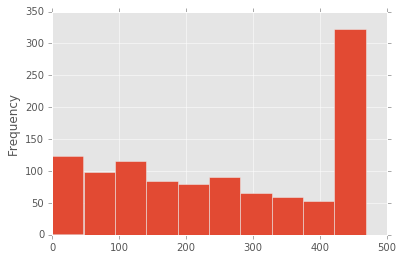

In [10]:
sessCombined.groupby("userId")['duration'].sum().plot.hist(bins=10)

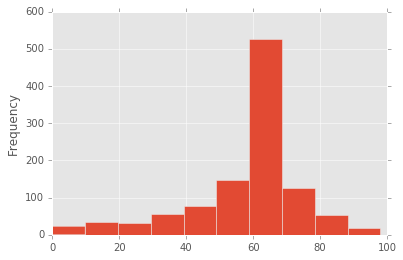

In [91]:
sessCombined.groupby("userId")['duration'].mean().plot.hist(bins=10)

In [11]:
sessTotal = sessCombined.groupby("userId")['duration'].sum().reset_index()
sessAvg = sessCombined.groupby("userId")['duration'].mean().reset_index()
duration = sessAvg.merge(sessTotal, on="userId")
duration.columns = ["userId","avg_hr","ttl_hr"]
duration.head(5)

,userId,avg_hr,ttl_hr
0,0,43.500000,174.0
1,1,62.285714,436.0
2,2,63.600000,318.0
3,6,74.000000,74.0
4,8,40.000000,80.0


In [12]:
gameDF = pd.read_csv("../from_coursera/big_data_capstone_datasets_and_scripts/flamingo-data/game-clicks.csv")
gameDF = gameDF.rename(columns=lambda x: x.strip())
gameDF.head(5)

,timestamp,clickId,userId,userSessionId,isHit,teamId,teamLevel
0,2016-05-26 15:06:55,105,1038,5916,0,25,1
1,2016-05-26 15:07:09,154,1099,5898,0,44,1
2,2016-05-26 15:07:14,229,899,5757,0,71,1
3,2016-05-26 15:07:14,322,2197,5854,0,99,1
4,2016-05-26 15:07:20,22,1362,5739,0,13,1


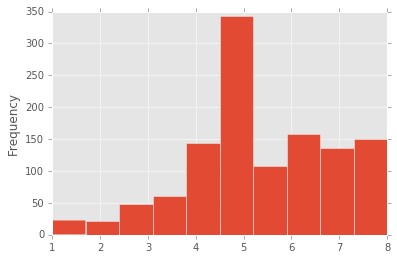

In [103]:
gameDF.groupby("userId")['teamLevel'].mean().plot.hist(bins=10)

In [48]:
gameDF['click'] = 1
clickSessDF = gameDF.groupby("userSessionId")['click'].sum().reset_index()
clickCombined = clickSessDF.merge(sessCombined,on='userSessionId')
# remove duration = 0
clickCombined = clickCombined[clickCombined['duration'] > 0]
clickCombined['click_per_hr'] = clickCombined['click'] / clickCombined['duration']
clickCombined.head(5)

,userSessionId,click,userId,start,end,duration,click_per_hr
0,5648,69,812,2016-05-26 15:01:14,2016-05-27 23:06:54,32.0,2.15625
1,5649,31,1658,2016-05-26 14:39:49,2016-05-27 23:06:54,32.0,0.96875
2,5650,26,1589,2016-05-26 15:05:08,2016-05-27 23:06:54,32.0,0.81250
3,5651,35,1863,2016-05-26 14:58:07,2016-05-27 23:06:54,32.0,1.09375
4,5652,39,937,2016-05-26 14:54:15,2016-05-27 23:06:54,32.0,1.21875


In [49]:
clickPerHour = clickCombined.groupby("userId")['click_per_hr'].mean().reset_index()
clickPerHour.head(5)

,userId,click_per_hr
0,0,7.700833
1,1,1.663700
2,2,0.850011
3,6,1.216216
4,8,2.826389


In [50]:
level = gameDF.groupby("userId")['teamLevel'].mean().reset_index()
level.columns=['userId','avg_level']
level.head(5)

,userId,avg_level
0,0,2.757934
1,1,4.518156
2,2,5.952381
3,6,7.403974
4,8,5.389474


In [51]:
# filter only top3 buyer game info
# How many hits they made?
hits = gameDF.groupby('userId')['isHit'].sum()
# What is the total number of challenge?
ttl_cnt = gameDF.groupby('userId')['isHit'].size()
# Calculate Hit Accuracy
accuracy = pd.DataFrame(100 * hits/ttl_cnt).reset_index()
accuracy.columns = ['userId','accuracy']
accuracy.head(5)

,userId,accuracy
0,0,10.553506
1,1,13.407821
2,2,9.523810
3,6,10.596026
4,8,10.000000


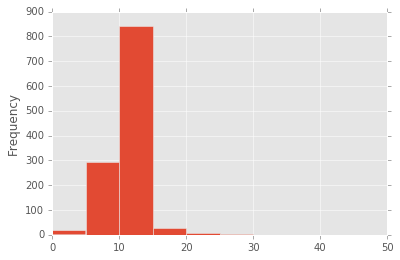

In [52]:
accuracy.groupby("userId")['accuracy'].mean().plot.hist(bins=10)

In [53]:
userPurchases = buyclicksDF[['userId','price']] 
userPurchases.head(5)

,userId,price
0,1300,3.0
1,868,10.0
2,819,20.0
3,121,3.0
4,2222,20.0


In [54]:
useradClicks = adclicksDF[['userId','adCount']]
useradClicks.head(5)

,userId,adCount
0,611,1
1,1874,1
2,2139,1
3,212,1
4,1027,1


In [55]:
adsPerUser = useradClicks.groupby('userId').sum()
adsPerUser = adsPerUser.reset_index()
adsPerUser.columns = ['userId', 'totalAdClicks'] #rename the columns
adsPerUser.head(n=5)

,userId,totalAdClicks
0,1,44
1,8,10
2,9,37
3,10,19
4,12,46


In [56]:
revenuePerUser = userPurchases.groupby('userId').sum()
revenuePerUser = revenuePerUser.reset_index()
revenuePerUser.columns = ['userId', 'revenue'] #rename the columns
revenuePerUser.head(n=5)

,userId,revenue
0,1,21.0
1,8,53.0
2,9,80.0
3,10,11.0
4,12,215.0


In [57]:
combinedDF = adsPerUser.merge(revenuePerUser, on='userId') #userId, adCount, price
combinedDF = combinedDF.merge(accuracy, on='userId')
combinedDF = combinedDF.merge(duration, on='userId')
combinedDF = combinedDF.merge(level, on='userId')
combinedDF = combinedDF.merge(clickPerHour, on='userId')
clickPerHour
combinedDF.head(5)

,userId,totalAdClicks,revenue,accuracy,avg_hr,ttl_hr,avg_level,click_per_hr
0,1,44,21.0,13.407821,62.285714,436.0,4.518156,1.663700
1,8,10,53.0,10.000000,40.000000,80.0,5.389474,2.826389
2,9,37,80.0,12.204724,62.500000,375.0,5.440945,1.260176
3,10,19,11.0,10.943032,50.800000,254.0,2.918571,13.021472
4,12,46,215.0,13.068182,59.142857,414.0,4.637784,1.920173


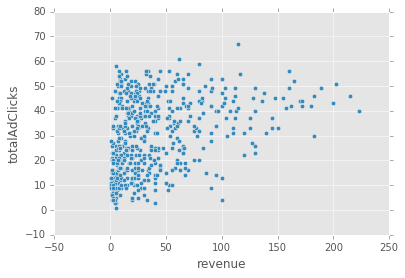

In [58]:
combinedDF.plot.scatter('revenue','totalAdClicks')

In [62]:
trainingDF = combinedDF[['totalAdClicks','revenue','accuracy','click_per_hr','avg_level','ttl_hr']]
trainingDF.head(n=5)

,totalAdClicks,revenue,accuracy,click_per_hr,avg_level,ttl_hr
0,44,21.0,13.407821,1.663700,4.518156,436.0
1,10,53.0,10.000000,2.826389,5.389474,80.0
2,37,80.0,12.204724,1.260176,5.440945,375.0
3,19,11.0,10.943032,13.021472,2.918571,254.0
4,46,215.0,13.068182,1.920173,4.637784,414.0


In [64]:
trainingDF.shape

(528, 6)

In [63]:
trainingDF.to_csv("training.csv",index=False)
print("done")

done


In [66]:
result = [
    trainingDF.columns,
[  44.37209302,   58.34883721,   11.7337892 ,    1.99138353, 4.69236249,  423.82790698], 
[  27.89542484,   35.32679739,   11.39957432,    3.48512431, 5.35885299,  252.69281046], 
[ 13.05625   ,  19.83125   ,  10.95881922,   3.58715502, 5.79436144,  92.45625   ]
]
pd.DataFrame(result)

,0,1,2,3,4,5
0,totalAdClicks,revenue,accuracy,click_per_hr,avg_level,ttl_hr
1,44.3721,58.3488,11.7338,1.99138,4.69236,423.828
2,27.8954,35.3268,11.3996,3.48512,5.35885,252.693
3,13.0563,19.8313,10.9588,3.58716,5.79436,92.4562
